Problem: Friedman-1 regression

__\<INCLUDE FORMULA\>__

Description: Page 207 DEAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# used libraries
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

sys.path.append(os.path.join('..', '..'))
import pywinEA2 as pea

pea.USE_NOTEBOOK_ENVIRONMENT = False

In [3]:
def getDataset() -> pd.DataFrame:
    """ Create the testing dataset """
    X, y = datasets.make_friedman1(
        n_samples=200,
        n_features=90,
        noise=0.5,
        random_state=1997)
    
    X = pd.DataFrame(X, columns=['feat_{}'.format(f) for f in range(X.shape[1])])
    y = pd.DataFrame(y, columns=['target'])
    data = pd.concat([X, y], axis=1)
    
    return data

In [4]:
data = getDataset()
data.head(5)

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,target
0,0.771148,0.074757,0.526310,0.975088,0.992226,0.465135,0.611135,0.569463,0.667719,0.786780,...,0.739056,0.189999,0.354658,0.213068,0.424554,0.320884,0.967451,0.063337,0.225850,16.864643
1,0.944677,0.166228,0.077853,0.717844,0.920020,0.615669,0.299287,0.847137,0.508283,0.131813,...,0.266088,0.491251,0.377104,0.265917,0.857921,0.914392,0.771561,0.187760,0.384997,20.389099
2,0.217790,0.972564,0.403189,0.872092,0.682622,0.445948,0.288469,0.761892,0.621428,0.208704,...,0.212825,0.341531,0.144842,0.435395,0.022645,0.667047,0.036734,0.655309,0.418235,18.261778
3,0.422399,0.438913,0.771213,0.502754,0.824081,0.200905,0.374775,0.723844,0.835281,0.951988,...,0.629061,0.112162,0.667163,0.303717,0.528023,0.122898,0.449646,0.511640,0.581908,15.298821
4,0.341653,0.076352,0.535166,0.679331,0.747861,0.665039,0.877723,0.025591,0.277263,0.648561,...,0.053892,0.553951,0.727013,0.407122,0.062515,0.518457,0.470395,0.892971,0.454677,11.989297


In [5]:
# create the model
model = SVR()

# create fitness function
fitness_function = pea.fitness.FeatureSelectionFitness(
    model=model,
    score='mean_squared_error',
    X=data[[c for c in data.columns if c.startswith('feat')]].values,
    y=data['target'],
    X_fixed=None,
    cv=None,
    n_jobs=1
)

In [ ]:
report = pea.pso.psoSimple(
    population_size=500,
    fitness_function=fitness_function,
    max_iterations=100,
    pso_evaluation='binary',
    pso_evaluation_kw=dict(
        invert_objective=True, 
        threshold=0.7,
        n_jobs=15
    ),
    pso_reference_update='simple',
    particle_update='simple',
    particle_update_kw=dict(
        inertia=0.2,
        acc_const1=0.1,
        acc_const2=0.2,
        clip_values=(0, 1)
    ),
    particle_init_position='random',
    particle_init_speed='random',
    report=pea.pso.PSOReport(['min', 'max', 'mean', 'std']),
    verbose=True,
    seed=1997
    
    
)

In [ ]:
report.displayConvergence()

In [ ]:
data[[c for c in data.columns if c.startswith('feat')]].iloc[:, report.particles[0].gbest > 0.7]

In [10]:
report2, features = pea.pso.vlpso(
    population_size=100,
    num_population_div=5,
    fitness_function=fitness_function,
    max_iterations=200,
    rank_function='pearsonCorrImportance',
    alpha=10,
    beta=25,
    pso_evaluation='binary',
    pso_evaluation_kw=dict(
        invert_objective=True, 
        threshold=0.5,
        n_jobs=15
    ),
    pso_reference_update='simple',
    particle_update_kw=dict(
        inertia=0.2,
        acc_const1=0.2,
        acc_const2=0.1,
        clip_values=(0, 1)
    ),
    particle_init_position='random',
    particle_init_speed='random',
    report=pea.pso.PSOReport(['min', 'max', 'mean', 'std']),
    verbose=True,
    seed=1997
)

100%|█████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.81it/s]


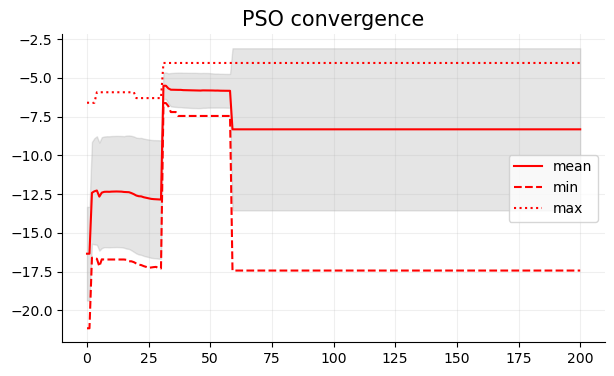

In [11]:
report2[0].displayConvergence()

In [ ]:
data[[c for c in data.columns if c.startswith('feat')]].iloc[:, report2.particles[0].gbest > 0.7]

In [12]:
report2[0].particles[0].gbest

array([0.65437169, 0.6049416 , 0.94921174, 0.85214177])

In [13]:
report2[1][:len(report2[0].particles[0].gbest)]

['feat_3', 'feat_0', 'feat_1', 'feat_4']